In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('sales2.xlsx')
df.head(3)

,Период продаж,"Средняя цена «ОАЭ ТУР», руб./заказ","Средняя цена конкурента, руб./заказ","Факт продаж, заказов"
0,12.03.2018 - 18.03.2018,103197.80,125185.20,197.0
1,19.03.2018 - 25.03.2018,107808.30,111489.70,155.0
2,26.03.2018 - 01.04.2018,92518.58,98027.54,124.0


In [3]:
df['week'] = pd.to_datetime(pd.Series([i[:10] for i in df['Период продаж']]), dayfirst=1).apply(lambda x : x.weekofyear)
df['start_week'] =pd.to_datetime([i[:10] for i in df['Период продаж']], dayfirst=1)

# Переименовываем поля
df = df.rename(columns={'Период продаж': 'period', 
                        'Средняя цена «ОАЭ ТУР», руб./заказ': 'price',
                       'Средняя цена конкурента, руб./заказ': 'market_price',
                       'Факт продаж, заказов' : 'qnt'})
df.head(3)

,period,price,market_price,qnt,week,start_week
0,12.03.2018 - 18.03.2018,103197.80,125185.20,197.0,11,2018-03-12
1,19.03.2018 - 25.03.2018,107808.30,111489.70,155.0,12,2018-03-19
2,26.03.2018 - 01.04.2018,92518.58,98027.54,124.0,13,2018-03-26


# Пробуем обучить модель с указанием номера недели года в качестве предиктора

In [4]:
column = ['week', 'price', 'market_price']

X = df[column].iloc[:df.qnt.dropna().shape[0],:]
y = df.qnt.iloc[:df.qnt.dropna().shape[0]]
X_test = df[column].iloc[df.qnt.dropna().shape[0]:,:]

In [5]:
from sklearn import model_selection, metrics
import xgboost as xgb

# делаем разбивку на обучающие и тестовые множества, причем размер тестовой выборки берем минимальный, 
# чтобы выжать как можно больше информации из обучающей, а недостаточный размер тестовой выборки компенсируем 
# большим количеством деревьев
train_data, test_data, train_labels, test_labels = model_selection. \
train_test_split(X, y, test_size = 0.03, random_state = 0)

#cv = model_selection.RepeatedKFold(n_splits=25)

XGB_estimator = xgb.XGBRegressor()

params = {
    'booster' : ['gbtree'],
    'min_child_weight' : [4],
    'n_estimators' : list(range(50, 151, 20)),
    'max_depth' : [3],  #list(range(3, 6)),
    'learning_rate' : [0.77] #np.linspace(0.001, 0.01, num = 5)
    }

grid_cv = model_selection.GridSearchCV(XGB_estimator, params, scoring = 'r2', cv = 2, n_jobs = -1)

In [6]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 2.88 s


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'booster': ['gbtree'], 'min_child_weight': [4], 'n_estimators': [50, 70, 90, 110, 130, 150], 'max_depth': [3], 'learning_rate': [0.77]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [7]:
print (grid_cv.best_params_)

booster_train = grid_cv.predict(X)
booster_test = grid_cv.predict(X_test)

print(metrics.mean_absolute_error(y, booster_train))
print(metrics.r2_score(y, booster_train))
print(list(map(lambda x : round(x), booster_test)))

{'booster': 'gbtree', 'learning_rate': 0.77, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 50}
1.4633733658563524
0.987232091801903
[136.0, 155.0, 143.0, 174.0, 141.0, 133.0, 133.0, 133.0, 130.0, 134.0]


# Получили достаточно высокую точность проноза на тесте, но так ли полезен в роли предиктора номер недели года? Ведь в датасете нет полного годового цикла, чтобы номер недели обрёл какой-то смысл.

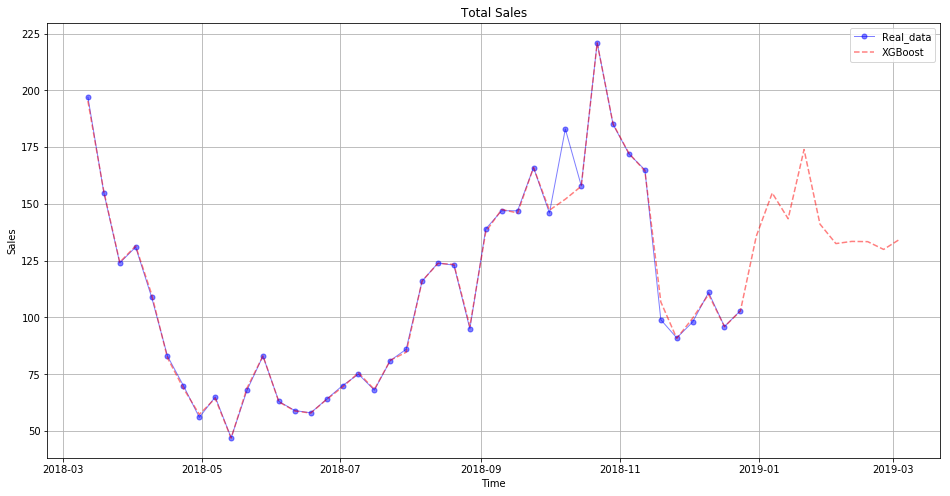

In [8]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.title('Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['start_week'], df['qnt'], color='b', marker='o', linestyle='-', 
         linewidth=1, alpha=0.5, markersize=5, label ='Real_data');
plt.plot(df['start_week'], np.append(booster_train, booster_test), alpha=0.5,
         color='r', linestyle='--', label ='XGBoost');
plt.legend(loc="best");

# Теперь попробуем обучить модель с использованием сквозной нумерации периодов наблюдений, т.е. возьмем порядкой номер периода в качестве регрессора

In [9]:
# Добавляем поле с порядковым номером периода
df['num'] = [x+1 for x in range(len(df.period))]

In [10]:
column = ['num', 'price', 'market_price']

X = df[column].iloc[:df.qnt.dropna().shape[0],:]
y = df.qnt.iloc[:df.qnt.dropna().shape[0]]
X_test = df[column].iloc[df.qnt.dropna().shape[0]:,:]

In [11]:
train_data, test_data, train_labels, test_labels = model_selection. \
train_test_split(X, y, test_size = 0.03, random_state = 0)

cv = model_selection.RepeatedKFold(n_splits=25)

XGB_estimator = xgb.XGBRegressor()

params = {
    'booster' : ['gbtree'],
    'min_child_weight' : [4],
    'n_estimators' : list(range(50, 151, 20)),
    'max_depth' : [3],  #list(range(3, 6)),
    'learning_rate' : [0.77] #np.linspace(0.001, 0.01, num = 5)
    }

grid_cv = model_selection.GridSearchCV(XGB_estimator, params, scoring = 'r2', cv = cv, n_jobs = -1)
grid_cv.fit(train_data, train_labels)

print (grid_cv.best_params_)

booster_train_n = grid_cv.predict(X)
booster_test_n = grid_cv.predict(X_test)

print(metrics.mean_absolute_error(y, booster_train_n))
print(metrics.r2_score(y, booster_train_n))
print(list(map(lambda x : round(x), booster_test_n)))

{'booster': 'gbtree', 'learning_rate': 0.77, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 50}
1.4633733658563524
0.987232091801903
[92.0, 110.0, 95.0, 101.0, 93.0, 84.0, 85.0, 98.0, 75.0, 125.0]


C:\Users\1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


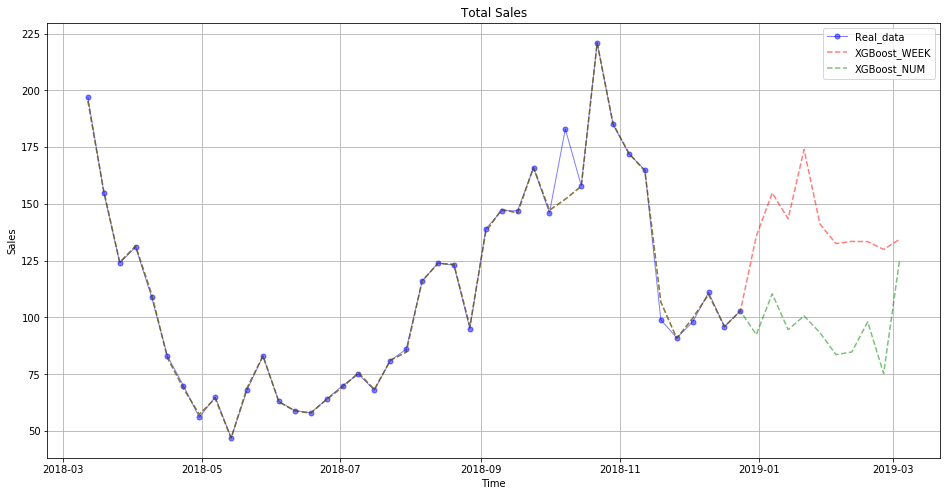

In [12]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.title('Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['start_week'], df['qnt'], color='b', marker='o', linestyle='-', 
         linewidth=1, alpha=0.5, markersize=5, label ='Real_data');
plt.plot(df['start_week'], np.append(booster_train, booster_test), alpha=0.5,
         color='r', linestyle='--', label ='XGBoost_WEEK');
plt.plot(df['start_week'], np.append(booster_train_n, booster_test_n), alpha=0.5,
         color='g', linestyle='--', label ='XGBoost_NUM');
plt.legend(loc="best");

# Обучив модель с использованием порядкого номера, получили прогноз с такой же высокой степенью доверия но с совершенно другими результатами на тесте

# Пытаемся увидеть наличие закономерностей и понять как влияет разница цен на объем продаж

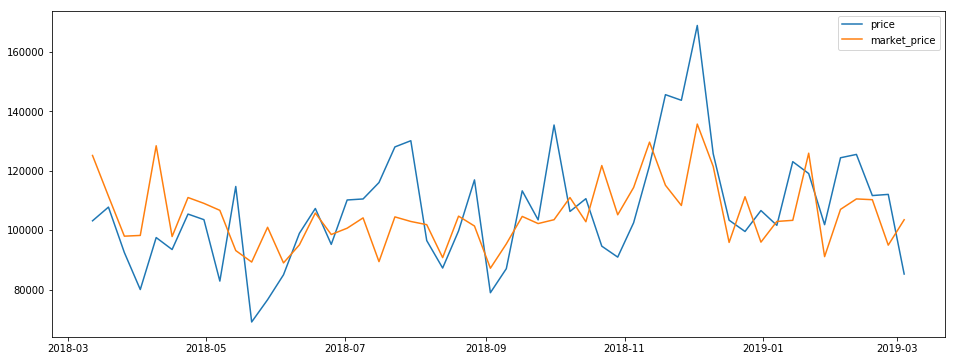

In [13]:
plt.figure(figsize=(16,6))
plt.plot(df['start_week'], df['price'], label='price');
plt.plot(df['start_week'], df['market_price'], label='market_price');
plt.legend(loc='best');

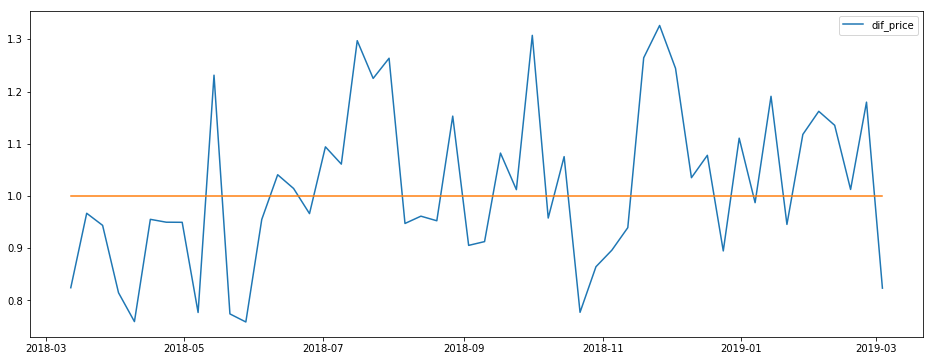

In [14]:
df['dif_price'] = df['price']/df['market_price']
#df['dif_price_ewm'] = df.dif_price.rolling(window=4, min_periods=1, win_type='triang').mean()

plt.figure(figsize=(16,6))
plt.plot(df['start_week'], df['dif_price'], label='dif_price')
plt.plot(df['start_week'], np.ones(len(df['start_week'])));
plt.legend(loc='best');

# Попробуем обучить модель опираясь исключительно на цены нашей компании и конкурентов. 

In [15]:
column = ['price', 'market_price']

X = df[column].iloc[:df.qnt.dropna().shape[0],:]
y = df.qnt.iloc[:df.qnt.dropna().shape[0]]
X_test = df[column].iloc[df.qnt.dropna().shape[0]:,:]

In [56]:
from sklearn import model_selection, metrics
import xgboost as xgb

train_data, test_data, train_labels, test_labels = model_selection. \
train_test_split(X, y, test_size = 0.03, random_state = 42, shuffle=1)

#cv = model_selection.RepeatedKFold(n_splits=10, n_repeats = 5)

cv = model_selection.ShuffleSplit(n_splits=30, test_size=0.03, random_state=42)

tscv = model_selection.TimeSeriesSplit(n_splits=15)

lr = np.linspace(0.01, 1, num = 10)
est = list(range(70, 151, 1))
mchw = list(range(2, 7))
max_d = list(range(2, 7))
subsam =   np.linspace(0.5, 1, num = 20) #[0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.98, 1]
colsample = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
gammas =  np.linspace(0.01, 2, num = 30) 

maes = []
r2s = []
booster_tests = []
booster_trains = []

for i in est:
    
    
    params = {
        'booster' : ['gbtree'],
        'random_state' : [42],
        'subsample' : [0.98],
        'gamma' : [1.1],
        'colsample_bytree' : [0.1],
        'min_child_weight' : [2],
        'n_estimators' : [i],  #list(range(50, 151, 10)),
        'max_depth' : [3],  #list(range(3, 6)),
        'learning_rate' :  [0.45] #np.linspace(0.01, 1, num = 10)  
    }


    XGB_estimator = xgb.XGBRegressor()

    grid_cv = model_selection.GridSearchCV(XGB_estimator, params, scoring = 'r2', cv = 2, n_jobs = -1)

    grid_cv.fit(train_data, train_labels)
    
    booster_train_p = grid_cv.predict(X)
    booster_test_p = grid_cv.predict(X_test)
    
    booster_trains += booster_train_p,
    booster_tests += booster_test_p,
    #maes.append(metrics.mean_absolute_error(y, booster_train_p))
    r2s.append(metrics.r2_score(y, booster_train_p))
     

booster_train_max = booster_trains[np.argmax(r2s)]
booster_test_max = booster_tests[np.argmax(r2s)]




#print('learning_rate = {}'.format(lr[np.argmax(r2s)]))

print('-------------R2_score----------------')
print(list(map(lambda x : round(x, 3), r2s)))

print('Best_r2 = {}'.format(max(r2s)))

print('-------------Predict_values-----------')
print(list(map(lambda x : int(round(x)), booster_test_max)))

-------------R2_score----------------
[0.979, 0.98, 0.98, 0.98, 0.981, 0.981, 0.981, 0.981, 0.981, 0.981, 0.981, 0.981, 0.981, 0.981, 0.982, 0.981, 0.981, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.982, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.983, 0.984, 0.983, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984, 0.984]
Best_r2 = 0.9839021130402221
-------------Predict_values-----------
[90, 154, 149, 174, 101, 43, 150, 186, 109, 125]


In [52]:
np.linspace(0.01, 0.3, num = 30)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

In [47]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(XGB_estimator, X=train_data, y=train_labels, groups=None, cv=6, n_jobs=None, verbose=0, 
                  fit_params=None, pre_dispatch='2*n_jobs', method='predict')
pred

array([151.41759 , 119.13163 , 190.36177 , 165.1535  , 111.37835 ,
        88.80185 ,  68.35385 , 169.89722 , 109.347115, 103.505394,
       107.74991 , 102.67324 ,  91.34155 , 113.98323 , 111.6634  ,
       116.3226  ,  99.012054, 122.481125, 111.93079 , 129.23607 ,
       125.33268 , 110.64027 , 117.375015,  90.45732 , 119.39964 ,
        82.82984 , 114.91969 , 107.48514 ,  81.69766 ,  63.374966,
       129.68529 , 150.88878 ,  69.993996, 107.23686 ,  38.08365 ,
       134.097   , 132.27156 , 133.05067 , 118.99284 , 117.224396],
      dtype=float32)

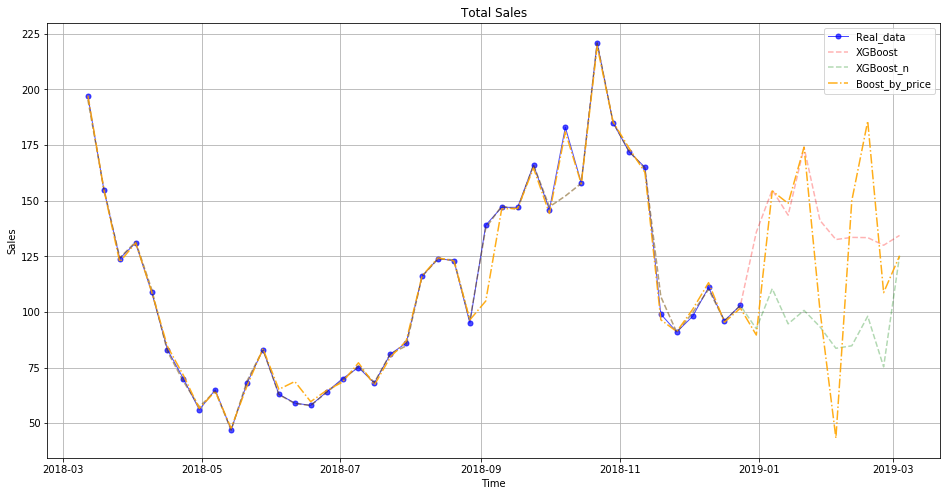

In [17]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.title('Total Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['start_week'], df['qnt'], color='b', marker='o', linestyle='-', 
         linewidth=1, alpha=0.7, markersize=5, label ='Real_data');
plt.plot(df['start_week'], np.append(booster_train, booster_test), alpha=0.3,
         color='r', linestyle='--', label ='XGBoost');
plt.plot(df['start_week'], np.append(booster_train_n, booster_test_n), alpha=0.3,
         color='g', linestyle='--', label ='XGBoost_n');
plt.plot(df['start_week'], np.append(booster_train_max, booster_test_max), alpha=0.9,
         color='orange', linestyle='-.', label ='Boost_by_price');
plt.legend(loc="best");

# Вывод: модель может восстанавливать зависимость продаж опираясь исключительно на цены (на их абсолютные величины и различия) с высоким коэффициентом детерминации R2 = 0,984. Стало быть отклонение цены от рыночной и есть главный фактор спроса.  

In [21]:
column = ['period', 'price', 'market_price']
X_test = df[column].iloc[df.qnt.dropna().shape[0]:,:]
X_test['predict'] = list(map(lambda x : int(round(x)), booster_test_max))
X_test

,period,price,market_price,predict
42,31.12.2018 - 06.01.2019,106651.70,96013.79,90
43,07.01.2019 - 13.01.2019,101673.50,102984.40,154
44,14.01.2019 - 20.01.2019,123099.70,103358.10,149
45,21.01.2019 - 27.01.2019,119102.70,125948.50,174
46,28.01.2019 - 03.02.2019,101896.10,91143.04,101
47,04.02.2019 - 10.02.2019,124413.50,107045.30,43
48,11.02.2019 - 17.02.2019,125538.70,110561.70,150
49,18.02.2019 - 24.02.2019,111693.30,110301.80,186
50,25.02.2019 - 03.03.2019,112086.90,95005.36,109
51,04.03.2019 - 10.03.2019,85283.17,103556.00,125
